# Global sensitivity Analysis for PULPO

In this notebook we show the workflow for the global sensitivity analysis (GSA) in PULPO.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
sys.path.append('../develop_test')
import stats as pulpostats
import numpy as np

## 1. Defining the case

The case for which the sensitivity analysis will be performed for is on a solution of the LP:

$$
    \begin{align}
        & \underset{s, slack}{\text{min}}  && z_h \\
        & \text{s.t.}   && \sum_{j}(a_{i,j}\cdot s_j) = f_i && \forall i \\
        &               && s_j^{low} \leq s_j \leq s_j^{high} && \forall j \\
        &               && z_h = \sum_e \sum_j (q_{h,e}\cdot b_{e,j} \cdot s_j) && \forall h \\
    \end{align}
$$


### 1.1. Rice husk problem


In [ ]:
case_study = pulpostats.RiceHuskCase()
case_study.create_pulpo_worker()
case_study.define_problem()
result_data = case_study.solve_and_summarize(file_name="rice_husc_test")


### 1.2. Defining the electricity showcase problem

In [2]:
case_study = pulpostats.ElectricityCase()
case_study.create_pulpo_worker()
case_study.define_problem()
result_data = case_study.solve_and_summarize(file_name='electricity_test')

Creating Instance
Instance created
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Cols:       39128 lower bounds exceeding       -1e+20 are treated as -Infinity
Cols:       39128 upper bounds exceeding        1e+20 are treated as +Infinity
Rows:       19561 lower bounds exceeding       -1e+20 are treated as -Infinity
Rows:       19562 upper bounds exceeding        1e+20 are treated as +Infinity

The following demand / functional unit has been specified:


,demand
"market for electricity, high voltage | electricity, high voltage | DE",1.288190e+11


No additional constraints have been passed.

Impacts contained in the objective:


,Key,Value
0,"('IPCC 2013', 'climate change', 'GWP 100a')",1.599836e+10



Impacts Calculated contained in the objective:


,Key,Value
0,"('ReCiPe Midpoint (E) V1.13', 'ionising radiat...",5.414918e+10
1,"('IPCC 2013', 'climate change', 'GWP 100a')",1.599836e+10
2,"('ReCiPe Endpoint (E,A)', 'human health', 'tot...",2.410592e+09
3,"('ReCiPe Endpoint (E,A)', 'resources', 'total')",6.763921e+08
4,"('ReCiPe Endpoint (E,A)', 'ecosystem quality',...",6.219297e+08



The following choices were made:


electricity                \
                                                     Process      Capacity   
Process 0  electricity production, nuclear, pressure wate...  1.000000e+16   
Process 1  electricity production, lignite | electricity,...  1.000000e+16   
Process 2  electricity production, hard coal | electricit...  1.000000e+16   
Process 3  electricity production, wind, 1-3MW turbine, o...  1.000000e+16   

                         
                  Value  
Process 0  8.350729e+10  
Process 1 -0.000000e+00  
Process 2 -0.000000e+00  
Process 3 -0.000000e+00

### 1.3. Defining the Ammonia case study

In [ ]:
case_study = pulpostats.AmmoniaCase()
case_study.create_pulpo_worker()
case_study.define_problem()
result_data = case_study.solve_and_summarize(file_name='ammonia_test')

## 2. Filtering out negletable uncertain parameters

**Reformulating the problem for the sensitivity analysis**

We only consider uncertainty in the $B$ and $Q$ parameter matrizes. The scaling vector is given by the optimal solution.

We will look at the environmental impact objective:

$$
    e(Q, B) =  Q \cdot B \cdot s
$$

In [3]:
impact_method = result_data['impacts']['Key'][0]

In [4]:
paramfilter = pulpostats.ParameterFilter(
    result_data=result_data, 
    lci_data=case_study.pulpo_worker.lci_data, 
    choices = case_study.choices,
    demand = case_study.demand,
    method = impact_method
    )

Using the basic scaling vector which only includes the optimal choices in the scaling vector

In [32]:
scaling_vector_series = paramfilter.prepare_sampling(scaling_vector_strategy='naive')

Using the scaling vector constructed from all choices

In [18]:
scaling_vector_series = paramfilter.prepare_sampling(scaling_vector_strategy='constructed_demand')

Compute the LCA scores and return the characterized inventory to be used for the filtering

In [33]:
lca_score, characterized_inventory = paramfilter.compute_LCI_LCIA(scaling_vector_series)

chosen environmental impact method: ('IPCC 2013', 'climate change', 'GWP 100a')
The total impact is: 1.599836e+10


Plot the largest contributors

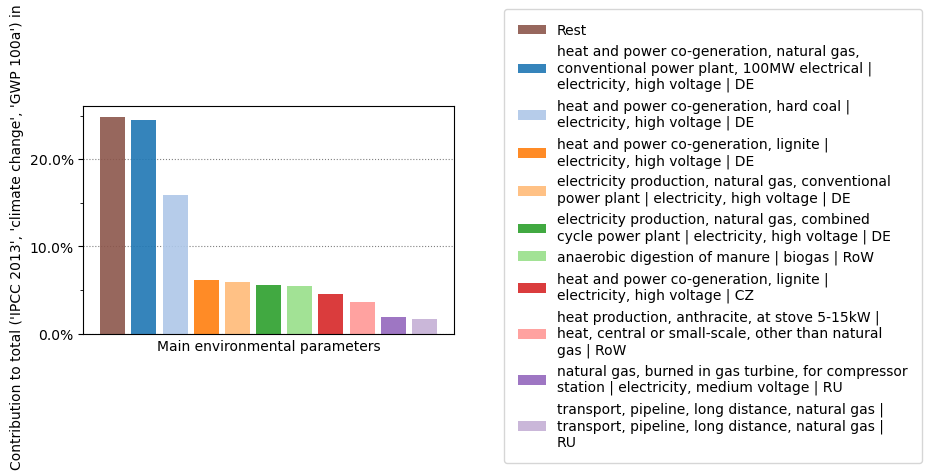

In [34]:
paramfilter.plot_top_processes(characterized_inventory)

Filtering out the inventoryflows $B_{i,j}$ that have a neglectable impact

In [21]:
cutoff = 0.00002
filtered_inventory_indcs = paramfilter.filter_inventoryflows(characterized_inventory, lca_score, cutoff)

Characterized inventory: (2171, 19565) 16559
Filtered characterized inventory: (2171, 19565) 364
Deviation from LCA score: 0.004385932810596849
inventory (2171, 19565) filtering resulted in 364 of 16559 exchanges (99.56% of total impact) and took 0.011 seconds.


In [22]:
filtered_characterization_indcs = paramfilter.filter_characterization_factors(filtered_inventory_indcs)

CHARACTERIZATION MATRIX (2171,) filtering resulted in 16 of 82 characterization factors


## 3. Getting the uncertainty of the parameter values

Extract the metadata containing the uncertainty information to the filtered intervention flows and characterization factors and seperate the metadata into the parameters with and without defined uncertainty information

In [23]:
uncertainty_importer = pulpostats.UncertaintyImporter(lci_data=case_study.pulpo_worker.lci_data)
inventory_metadata_df = uncertainty_importer.get_intervention_meta(inventory_indices=filtered_inventory_indcs)
inventory_defined,  inventory_undefined = uncertainty_importer.separate(inventory_metadata_df)
characterization_metadata_df = uncertainty_importer.get_cf_meta(
    characterization_indices=filtered_characterization_indcs,
    method=impact_method
    )
cf_defined,  cf_undefined = uncertainty_importer.separate(characterization_metadata_df)


Parameters with uncertainty information: 346 
Parameters without uncertainty information: 18
Parameters with uncertainty information: 0 
Parameters without uncertainty information: 16


Apply the triangular strategy using bound interpolation to the missing intervention uncertainty parameters

upper spread statistics
mean: 0.7545
mode: 0    0.525579
dtype: float64
median: 0.5730
std: 0.9648
min: 0.0805
max: 9.3910


lower spread statistics
mean: 0.3525
mode: 0    0.344511
dtype: float64
median: 0.3643
std: 0.1698
min: 0.0745
max: 0.9038

The upper spread scaling factor for intervention flows is: 0.5730084772150491
The lower spread scaling factor for intervention flows is: 0.3642755216477723
uncertain parameters with negative median value:
Empty DataFrame
Columns: [input, output, type, uncertainty_type, amount, loc, scale, shape, minimum, maximum, negative]
Index: []


/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:845: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.488072207635861' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'maximum'] = amount + upper_scaling_factor * abs(amount),
/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:846: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.8345627770847406' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'minimum'] = amount - lower_scaling_factor * abs(amount),


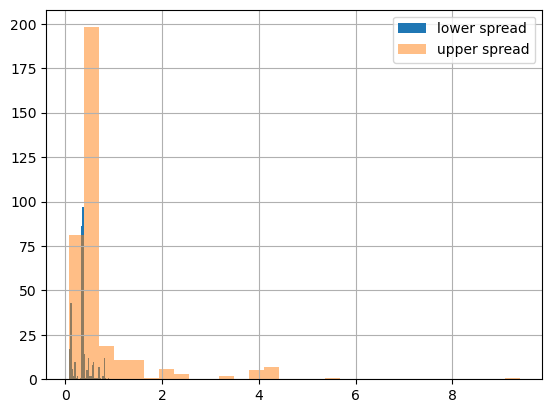

In [24]:
triangular_strategy_if = pulpostats.TriangularStrategy(
    metadata_df=inventory_metadata_df,
    defined_uncertainty_metadata=inventory_defined,
    undefined_uncertainty_indices= inventory_undefined
    )
upper_scaling_factor_if, lower_scaling_factor_if = triangular_strategy_if.compute_bounds_statistics()
if_metadata_asigned_df = triangular_strategy_if.assign(upper_scaling_factor_if, lower_scaling_factor_if)

Apply the triangular strategy using predefined scaling factors to the missing uncertainty parameters

In [25]:
upper_scaling_factor_cf = 0.15
lower_scaling_factor_cf = 0.15
triangular_strategy_cf = pulpostats.TriangularStrategy(
    metadata_df=characterization_metadata_df,
    defined_uncertainty_metadata=cf_defined,
    undefined_uncertainty_indices=cf_undefined
)
cf_metadata_asigned_df = triangular_strategy_cf.assign(upper_scaling_factor_cf, lower_scaling_factor_cf)

uncertain parameters with negative median value:
Empty DataFrame
Columns: [flow, geo, col, uncertainty_type, amount, loc, scale, shape, minimum, maximum, negative]
Index: []


/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:845: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.15' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'maximum'] = amount + upper_scaling_factor * abs(amount),
/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:846: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.85' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'minimum'] = amount - lower_scaling_factor * abs(amount),


## 4. Define the global sensitivity problem
### 4.1. Define the bound/interval of the parameters

Check if all parameters have gotten uncertainty information asigned

In [38]:
from SALib.sample import sobol as sample_method
from SALib.analyze import sobol as SA_method
N = 2**7

gsa = pulpostats.GlobalSensitivityAnalysis(
    result_data=result_data,
    lci_data=case_study.pulpo_worker.lci_data,
    cf_metadata_df=cf_metadata_asigned_df,
    if_metadata_df=if_metadata_asigned_df,
    sampler=sample_method,
    analyser=SA_method,
    sample_size=N,
    method=impact_method
)
gsa_problem, all_bounds_indx_dict = gsa.define_problem()

problem includes:
364 uncertain intervention flows
16 uncertain characterization factors


In [39]:
sample_data_if, sample_data_cf = gsa.sample(gsa_problem, all_bounds_indx_dict)

The statistics of the the sample impacts: ('IPCC 2013', 'climate change', 'GWP 100a')
count    9.753600e+04
mean     1.774651e+10
std      1.555608e+09
min      1.386228e+10
25%      1.662322e+10
50%      1.789061e+10
75%      1.881369e+10
max      2.259264e+10
dtype: float64
The deterministic impact is ('IPCC 2013', 'climate change', 'GWP 100a') : 1.599836e+10
(97536,)
the z-value of the total impact: 0.08765713035558513


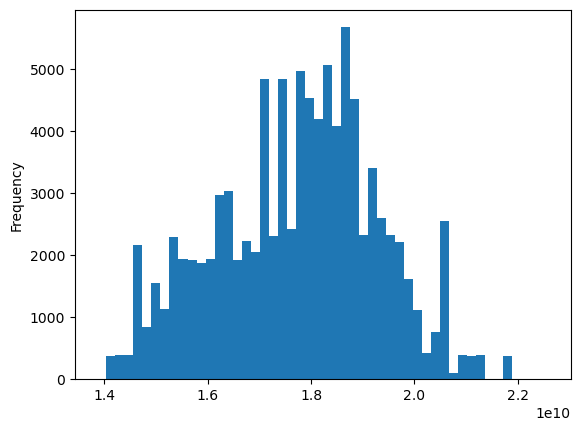

In [40]:
sample_impacts, sample_characterized_inventories = gsa.run_model(sample_data_if, sample_data_cf)

In [41]:
total_Si = gsa.analyze(gsa_problem, sample_impacts)

/Users/hausslingbhl/miniconda3/envs/pulpo_dev/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


The total explained variance is 
95.1%


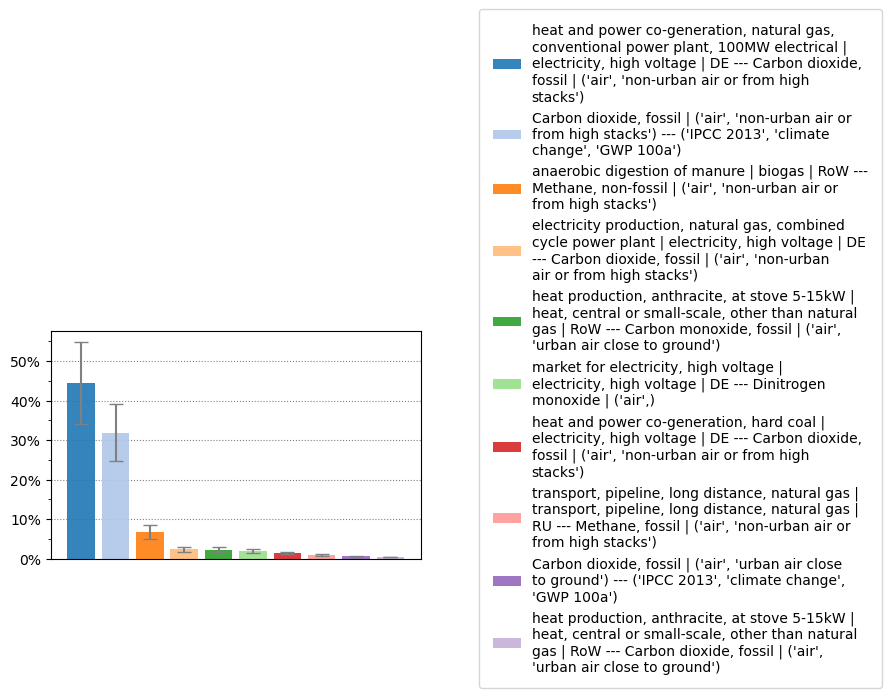

In [42]:
total_Si_metadata = gsa.generate_Si_metadata(all_bounds_indx_dict, total_Si)
colormap_base, colormap_SA_barplot = gsa.plot_top_total_sensitivity_indices(total_Si, total_Si_metadata)

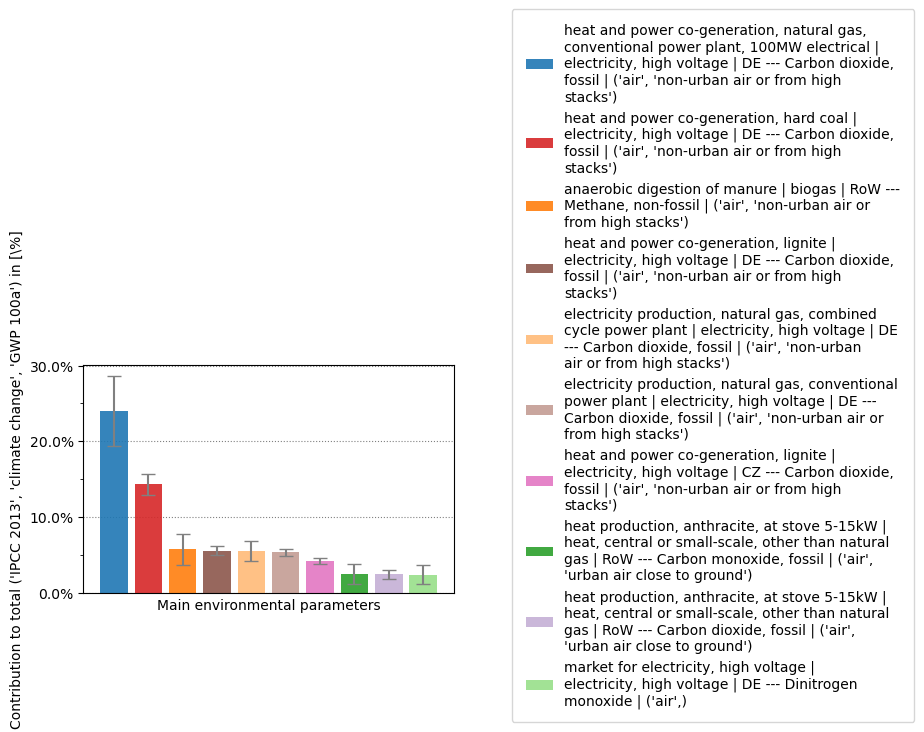

In [43]:
data_plot = gsa.plot_total_env_impact_contribution(
    sample_characterized_inventories, 
    total_Si_metadata, 
    colormap_base=colormap_base, 
    colormap_SA_barplot=colormap_SA_barplot,
    )

## 6. CC formulation

Formulate the chance constrain optimization problem. 

In the future multiple formulations might be possible, represented by different `CCFormulation` classes

16 parameters with non normal distribution are transformed into normal distributions via max likelihood approximation


/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:926: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0001286054408924' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  normal_uncertainty_metadata_df.loc[param_index] = normal_uncertainty_metadata
/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:926: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.061169772977307815' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  normal_uncertainty_metadata_df.loc[param_index] = normal_uncertainty_metadata
/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code

364 parameters with non normal distribution are transformed into normal distributions via max likelihood approximation


/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:926: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08494725046899089' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  normal_uncertainty_metadata_df.loc[param_index] = normal_uncertainty_metadata
/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:926: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.017708363310781905' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  normal_uncertainty_metadata_df.loc[param_index] = normal_uncertainty_metadata
/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Cod

These environmental costs have a standard deviation larger than 50% of their mean:

            std                                           metadata      mean  \
9358   2.038475  ferrochromium production, high-carbon, 68% Cr ...  1.511600   
7239   0.001526  market for electricity, high voltage | electri...  0.001324   
19119  0.015176  market for electricity, high voltage | electri...  0.013240   
2155   0.201156  hard coal mine operation | hard coal, run-of-m...  0.195416   
5380   0.007736                                coking | coke | RoW  0.008738   
13801  0.199614  natural gas production, unprocessed, at extrac...  0.261954   
15811  0.239755  natural gas production | natural gas, high pre...  0.316054   
10266  0.048218  treatment of lignite ash, sanitary landfill | ...  0.069976   
16154  0.228092  hard coal mine operation and hard coal prepara...  0.359489   
44     0.130933  hard coal mine operation and hard coal prepara...  0.236404   
12860  0.139797          iron sinter

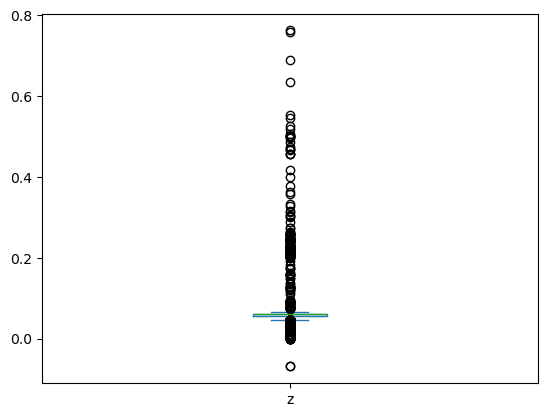

In [44]:
cc_formulation = pulpostats.CCFormulationIndividualNormalL1(
    cf_metadata_df=cf_metadata_asigned_df,
    if_metadata_df=if_metadata_asigned_df,
    pulpo_worker=case_study.pulpo_worker,
    method=impact_method,
    choices=case_study.choices,
    demand=case_study.demand
)

Initiate epsilon solver for the Pareto Problem

In [45]:
epsilon_pareto_solver = pulpostats.EpsilonConstraintSolver(cc_formulation)

Solve single Pareto point

In [46]:
CC_solution = epsilon_pareto_solver.solve_single_pareto_point(lambda_level=.5)
CC_solution

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Cols:       39128 lower bounds exceeding       -1e+20 are treated as -Infinity
Cols:       39128 upper bounds exceeding        1e+20 are treated as +Infinity
Rows:       19561 lower bounds exceeding       -1e+20 are treated as -Infinity
Rows:       19562 upper bounds exceeding        1e+20 are treated as +Infinity


{'impacts':                                            Key         Value
 0  ('IPCC 2013', 'climate change', 'GWP 100a')  1.599836e+10,
 'scaling_vector':           ID         Value                                  Process name  \
 0      14779  2.770870e+11  (cutoff38, 0cbb759cc5686df90185c3fbc7b8262b)   
 1        637  2.770870e+11  (cutoff38, 2040efe62886e6f108756a2b60d663a1)   
 2       7239  1.346918e+11  (cutoff38, 962727b9a36bcaa186f222b29b57f6a3)   
 3       6498  8.350729e+10  (cutoff38, 0058af82cdce10e512dc11f68a00a8eb)   
 4      15234  2.837404e+10  (cutoff38, e4b81a6357b79091e76dc2836ef1fc52)   
 ...      ...           ...                                           ...   
 19560   2028 -6.993395e+05  (cutoff38, 8e8cdd680e8d61271f4fa838a24bed1a)   
 19561  13440 -7.185991e+05  (cutoff38, 0bb079bf4e6142ad612b2b08e043f4ba)   
 19562   5551 -8.139695e+05  (cutoff38, 9b0bb421368f11d8ad6fd72066eca3d0)   
 19563  14649 -1.385271e+07  (cutoff38, 18955e2d43eeb55c9ae99705a5170cca)   

Solve for an array of lambda epsilon constraints

In [47]:
lambda_epsilon_array = np.linspace(0.5,1, 5, endpoint=False)
CC_solutions = epsilon_pareto_solver.solve(lambda_epsilon_array)

solving CC problem for lambda_QB = 0.5
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Cols:       39128 lower bounds exceeding       -1e+20 are treated as -Infinity
Cols:       39128 upper bounds exceeding        1e+20 are treated as +Infinity
Rows:       19561 lower bounds exceeding       -1e+20 are treated as -Infinity
Rows:       19562 upper bounds exceeding        1e+20 are treated as +Infinity
solving CC problem for lambda_QB = 0.6
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Cols:       39128 lower bounds exceeding       -1e+20 are treated as -Infinity
Cols:       39128 upper bounds exceeding        1e+20 are treated as +Infinity
Rows:       19561 lower bounds exceeding       -1e+20 are treated as -Infinity
Rows:       19562 upper bounds exceeding        1e+20 are treated as +Infinity
solving CC problem for lambda_QB = 0.7
Running HiGHS 1.5.3 [date: 2023-0

Plot Pareto front

With a cutoff value of 0.03, we keep 8 process to an error of 28.45%
With a cutoff value of 0.03, we keep 8 process to an error of 28.92%
With a cutoff value of 0.03, we keep 8 process to an error of 29.38%
With a cutoff value of 0.03, we keep 8 process to an error of 29.85%
With a cutoff value of 0.03, we keep 8 process to an error of 30.43%


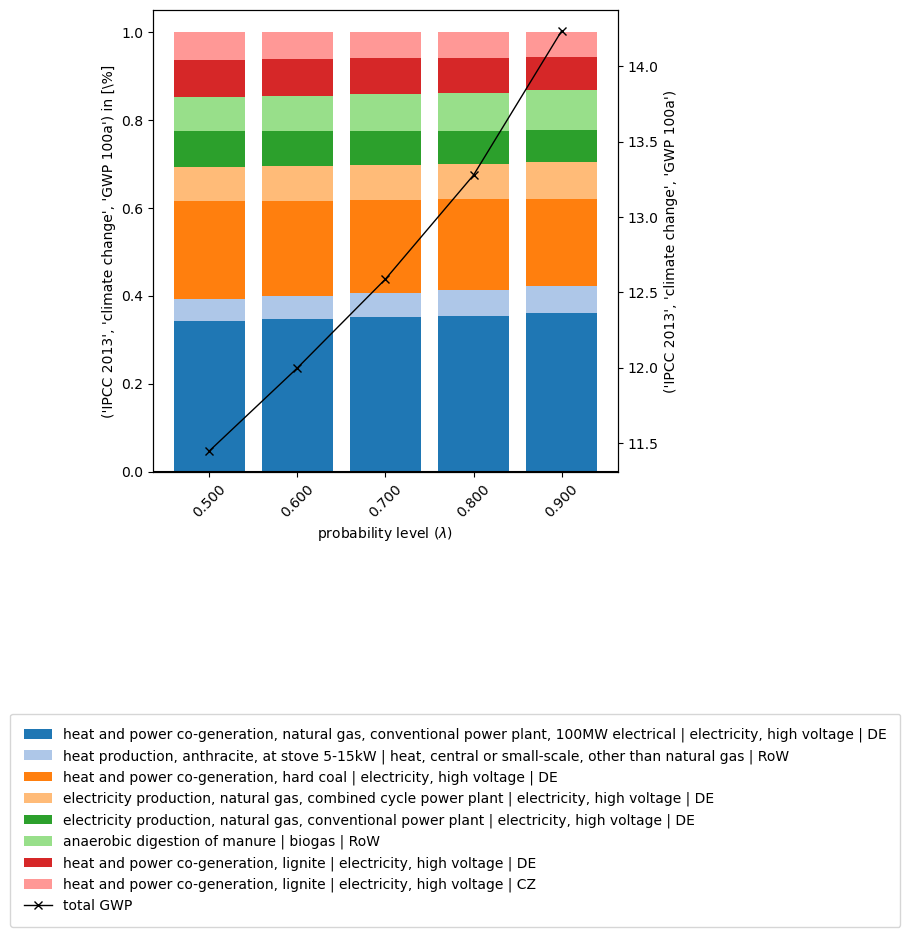

In [48]:
epsilon_pareto_solver.plot_pareto_front(CC_solutions, 0.03)

Compare the Pareto points

In [49]:
epsilon_pareto_solver.compare_subsequent_paretosolutions(CC_solutions)

('IPCC 2013', 'climate change', 'GWP 100a')
0.5: 15998358670.367128
0.6: 16880896668.83018
0.7: 17825114821.327126
0.8: 18930157415.826298
0.9: 20462660570.608173
electricity
                                                     Process      Capacity  \
Process 0  electricity production, nuclear, pressure wate...  1.000000e+16   
Process 1  electricity production, lignite | electricity,...  1.000000e+16   
Process 2  electricity production, hard coal | electricit...  1.000000e+16   
Process 3  electricity production, wind, 1-3MW turbine, o...  1.000000e+16   

                    0.5           0.6           0.7           0.8  \
Process 0  8.350729e+10  8.350729e+10  8.350729e+10  8.350729e+10   
Process 1 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00   
Process 2 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00   
Process 3 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00   

                    0.9  
Process 0  8.350729e+10  
Process 1 -0.000000e+00  
Process 2 